In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u
import matplotlib.gridspec as gridspec


In [ ]:
# List all CSV files in the directory
csv_files = glob.glob('/content/drive/MyDrive/spectra/new_plots/new/*.csv')

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

# Concatenate all dfs
spectral_index = pd.concat(dfs, ignore_index=True)
spectral_index.to_csv('/content/drive/MyDrive/spectra/all_matched_sources.csv', index=False)

In [ ]:
#A catalog of all the sources from the observed images
csv_files = glob.glob('/content/drive/MyDrive/spectra/new_plots/all_sources/*.srl')
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file,index_col = None,skiprows=5)
    dfs.append(df)
all_sources = pd.concat(dfs, ignore_index=True)
all_sources.to_csv('/content/drive/MyDrive/spectra/combined_data_all_sources.csv', index=False)

In [ ]:
all_sources.columns

Index(['# Source_id', ' Isl_id', ' RA', ' E_RA', ' DEC', ' E_DEC',
       ' Total_flux', ' E_Total_flux', ' Peak_flux', ' E_Peak_flux', ' RA_max',
       ' E_RA_max', ' DEC_max', ' E_DEC_max', ' Maj', ' E_Maj', ' Min',
       ' E_Min', ' PA', ' E_PA', ' Maj_img_plane', ' E_Maj_img_plane',
       ' Min_img_plane', ' E_Min_img_plane', ' PA_img_plane',
       ' E_PA_img_plane', ' DC_Maj', ' E_DC_Maj', ' DC_Min', ' E_DC_Min',
       ' DC_PA', ' E_DC_PA', ' DC_Maj_img_plane', ' E_DC_Maj_img_plane',
       ' DC_Min_img_plane', ' E_DC_Min_img_plane', ' DC_PA_img_plane',
       ' E_DC_PA_img_plane', ' Isl_Total_flux', ' E_Isl_Total_flux',
       ' Isl_rms', ' Isl_mean', ' Resid_Isl_rms', ' Resid_Isl_mean',
       ' S_Code'],
      dtype='object')

In [ ]:
#Defining Relations and new parameters

#S/N  Ratio of peak flux to the the ISM_rms which is considered as the local rms of the given source
all_sources['S/N'] = all_sources[' Peak_flux'] /all_sources[' Isl_rms']
spectral_index['S/N']= spectral_index[' Peak_flux']/spectral_index[' Isl_rms']

#Compactness : Defined as the inverse of the flux ratio i.e Si/Sp , The threshold is 1.5 to define a source to be compact

compact_threshold = 1.5

# Calculate aspect ratios for both datasets
all_sources['Flux_ratio'] = all_sources[' Total_flux'] / all_sources[' Peak_flux']
spectral_index['Flux_ratio'] = spectral_index[' Total_flux'] / spectral_index[' Peak_flux']

# Identify compact sources based on aspect ratio
compact_sources = all_sources[all_sources['Flux_ratio'] >= compact_threshold] # this will be a boolean array
matched_compact_sources = spectral_index[spectral_index['Flux_ratio'] >= compact_threshold]

#Make a column of the compactness parameter
all_sources['Compactness'] = 1.0/all_sources['Flux_ratio']
spectral_index['Compactness'] = 1.0/spectral_index['Flux_ratio']

#pulsar candidate classification to DataFrame boolean column
spectral_index['Pulsar_Candidate'] = spectral_index['Spectral_index'] <= -0.9
spectral_index['Pulsar_Candidate_spidx'] = spectral_index['Spidx'] <= -0.9

Histograms


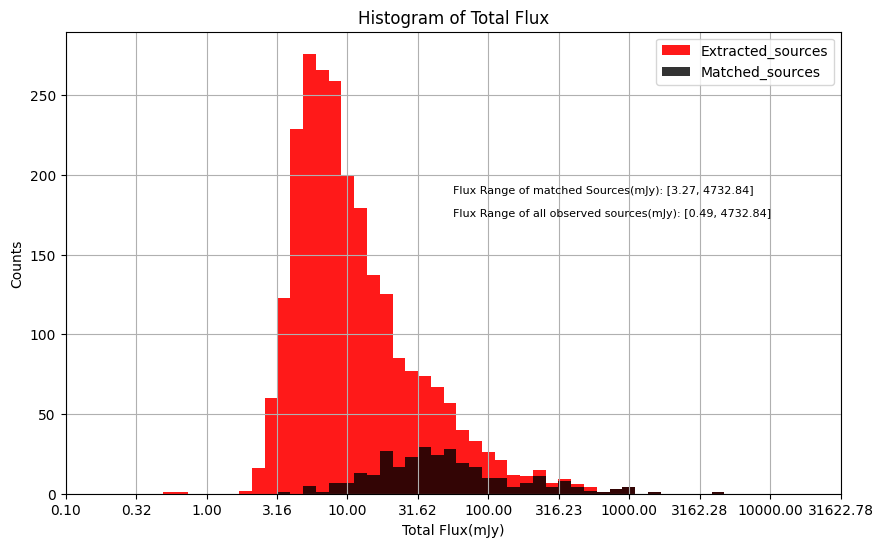

In [ ]:
# Logarithmically scale the flux values
total_flux = np.log10(all_sources[' Total_flux'] * 1000)
total_flux_m = np.log10(spectral_index[' Total_flux'] * 1000)

# Create the histogram with log-scaled bins
fig, ax = plt.subplots(figsize=(10, 6))
bins = np.histogram_bin_edges(np.concatenate((total_flux, total_flux_m)), bins='auto')
n_total_flux, bins_total_flux, _ = ax.hist(total_flux, bins=bins, alpha=0.9, color='red', label='Extracted_sources')
n_total_flux_m, _, _ = ax.hist(total_flux_m, bins=bins, color='black', alpha=0.8, label='Matched_sources')

# Set the x-axis ticks and labels to display a range of values
range_start = np.floor(np.min(bins_total_flux))
range_end = np.ceil(np.max(bins_total_flux))
ticks = np.arange(range_start, range_end + 1, step=0.5)  # Adjust the step as needed
labels = [f'{10**tick:.2f}' for tick in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, fontsize=10)

avg_flux = all_sources[' Total_flux'].mean()
min_flux = (all_sources[' Total_flux'].min()) * 1000
max_flux = (all_sources[' Total_flux'].max()) * 1000
min_flux_m = (spectral_index[' Total_flux'].min()) * 1000
max_flux_m = (spectral_index[' Total_flux'].max()) * 1000

plt.text(0.5, 0.6, f'Flux Range of all observed sources(mJy): [{min_flux:.2f}, {max_flux:.2f}]', transform=plt.gca().transAxes, fontsize=8, color='black')
plt.text(0.5, 0.65, f'Flux Range of matched Sources(mJy): [{min_flux_m:.2f}, {max_flux_m:.2f}]', transform=plt.gca().transAxes, fontsize=8, color='black')

plt.xlabel('Total Flux(mJy)')
plt.ylabel('Counts')
plt.title('Histogram of Total Flux')
plt.grid()
plt.legend()
plt.show()

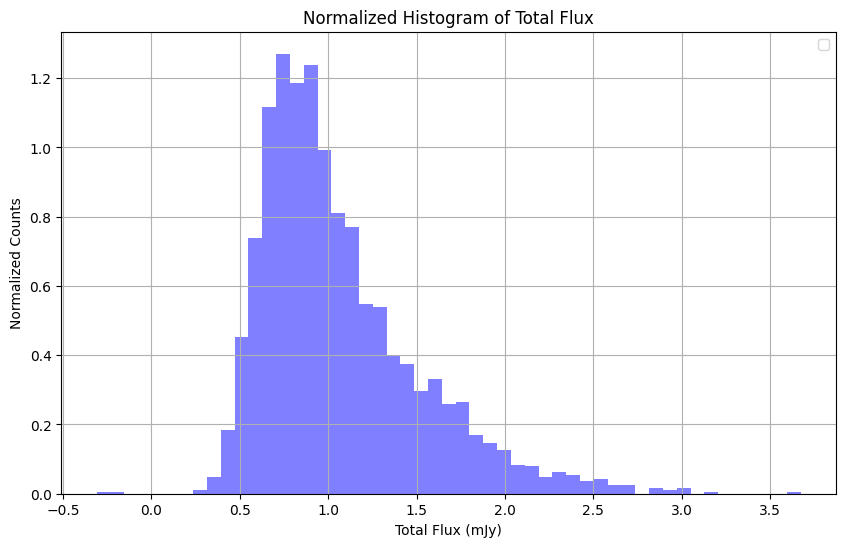

In [ ]:
#Normalized distribution of flux
# Multiply the data by 1000 to convert to mJy
total_flux = np.log10(all_sources[' Total_flux'] * 1000)

plt.figure(figsize=(10, 6))

plt.hist(total_flux, bins='auto', alpha=0.5, color='blue', density=True)  # Set density=True for normalization

avg_flux = all_sources[' Total_flux'].mean()
min_flux = (all_sources[' Total_flux'].min()) * 1000
max_flux = (all_sources[' Total_flux'].max()) * 1000

#plt.xlim((0, 200))
plt.xlabel('Total Flux (mJy)')
plt.ylabel('Normalized Counts')  # Change the label to indicate normalized counts
plt.title('Normalized Histogram of Total Flux')
plt.grid()
plt.legend()
plt.show()

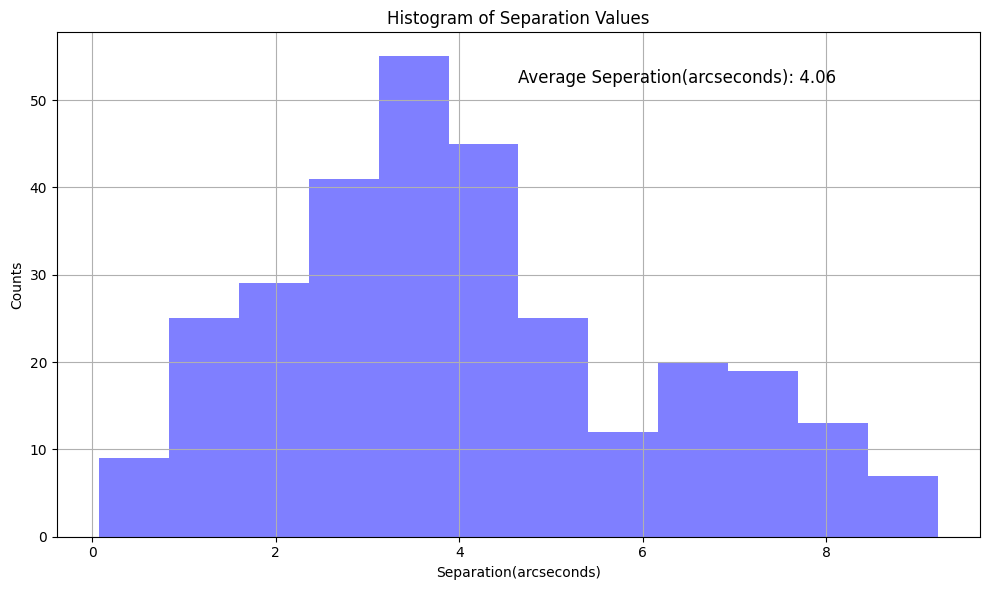

In [ ]:
# Plot histogram of 'Sep' values
plt.figure(figsize=(10, 6))
plt.hist(spectral_index['sep_arcsecods'], bins='auto', color='blue', histtype='bar', alpha=0.5)
plt.xlabel('Separation(arcseconds)')
plt.ylabel('Counts')
plt.title('Histogram of Separation Values')
plt.grid()

# Calculate and display the average Spectral Index
avg_spectral_index = spectral_index['sep_arcsecods'].mean()
plt.text(0.5, 0.9, f'Average Seperation(arcseconds): {avg_spectral_index:.2f}', transform=plt.gca().transAxes, fontsize=12, color='black')

plt.tight_layout()
plt.show()

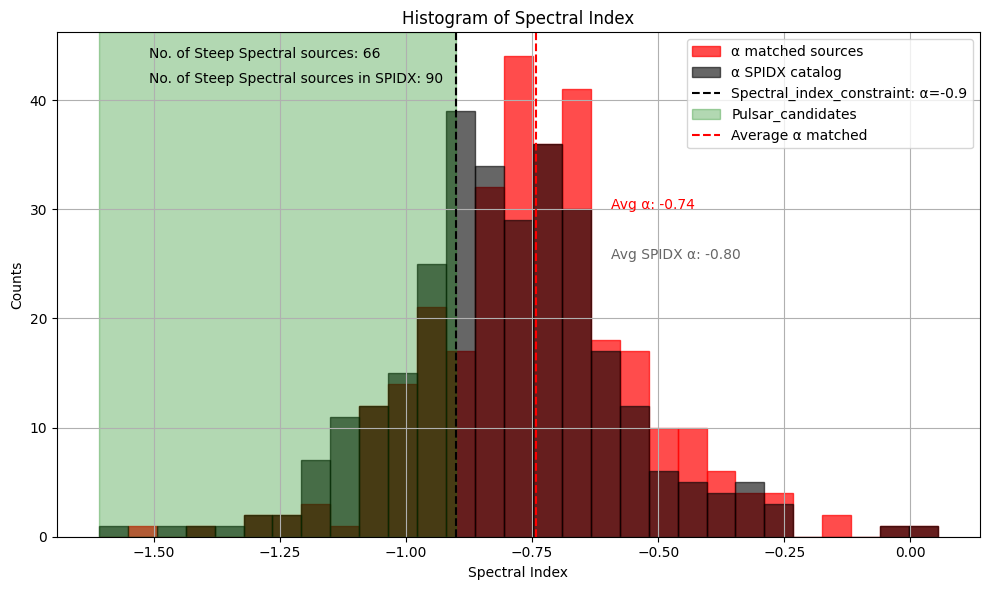

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
bins = np.histogram_bin_edges(np.concatenate((spectral_index['Spectral_index'], spectral_index['Spidx'])), bins='auto')
# Plot histogram of 'Spectral_index' values
ax.hist(spectral_index['Spectral_index'], bins=bins, color='red', edgecolor='red', alpha=0.7, histtype='bar', label='α matched sources')
ax.hist(spectral_index['Spidx'], bins=bins, color='black', edgecolor='black', alpha=0.6, histtype='bar', label='α SPIDX catalog')

# Count the number of pulsar candidates
num_pulsar_candidates = spectral_index['Pulsar_Candidate'].sum()
num_pulsar_candidates_spidx = spectral_index['Pulsar_Candidate_spidx'].sum()

# Add text annotations
ax.text(0.1, 0.95, f'No. of Steep Spectral sources: {num_pulsar_candidates:.0f}', transform=ax.transAxes, fontsize=10, color='black')
ax.text(0.1, 0.9, f'No. of Steep Spectral sources in SPIDX: {num_pulsar_candidates_spidx:.0f}', transform=ax.transAxes, fontsize=10, color='black')

# Add vertical line for spectral index constraint
ax.axvline(x=-0.9, color='black', linestyle='--', label='Spectral_index_constraint: α=-0.9')

# Add shaded region for pulsar candidates
ax.axvspan(xmin=spectral_index['Spidx'].min(), xmax=-0.9, alpha=0.3, color='g', label='Pulsar_candidates')

# Set labels, title, legend, and grid
ax.set_xlabel('Spectral Index')
ax.set_ylabel('Counts')
ax.legend()
ax.set_title('Histogram of Spectral Index')
ax.grid()

# Calculate and display the average Spectral Index
avg_spectral_index = spectral_index['Spectral_index'].mean()
ax.text(0.6, 0.65, f'Avg α: {avg_spectral_index:.2f}', transform=ax.transAxes, fontsize=10, color='red')
ax.axvline(x=avg_spectral_index, color='red', linestyle='--',label='Average α matched')

avg_spectral_index_1 = spectral_index['Spidx'].mean()
ax.text(0.6, 0.55, f'Avg SPIDX α: {avg_spectral_index_1:.2f}', transform=ax.transAxes, fontsize=10, color='black',alpha=0.6)
ax.legend()
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

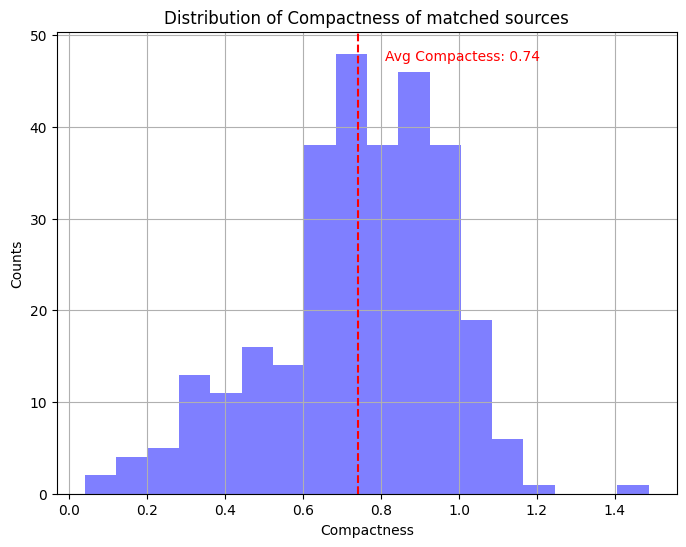

In [ ]:
# Plot histogram of compactness for AIPS
plt.figure(figsize=(8, 6))
plt.hist(spectral_index['Compactness'], bins='auto', color='blue', alpha=0.5)
avg_compactness = spectral_index['Compactness'].mean()
plt.text(0.35, 0.85, f'Avg Compactess: {avg_compactness:.2f}', transform=ax.transAxes, fontsize=10, color='red')
plt.axvline(x=avg_compactness, color='red', linestyle='--')
plt.xlabel('Compactness')
plt.ylabel('Counts')
plt.title('Distribution of Compactness of matched sources')
plt.grid()
plt.show()

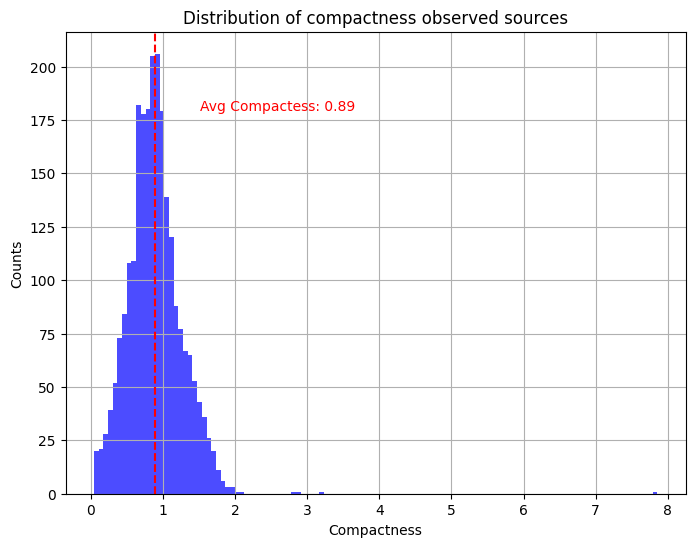

In [ ]:
# Plot histogram of compactness for AIPS
plt.figure(figsize=(8, 6))
plt.hist(all_sources['Compactness'], bins='auto', color='blue', alpha=0.7)
avg_compactness = all_sources['Compactness'].mean()
plt.text(0.15, 0.75, f'Avg Compactess: {avg_compactness:.2f}', transform=ax.transAxes, fontsize=10, color='red')
plt.axvline(x=avg_compactness, color='red', linestyle='--')
plt.xlabel('Compactness')
plt.ylabel('Counts')
plt.title('Distribution of compactness observed sources')
plt.grid()
plt.show()

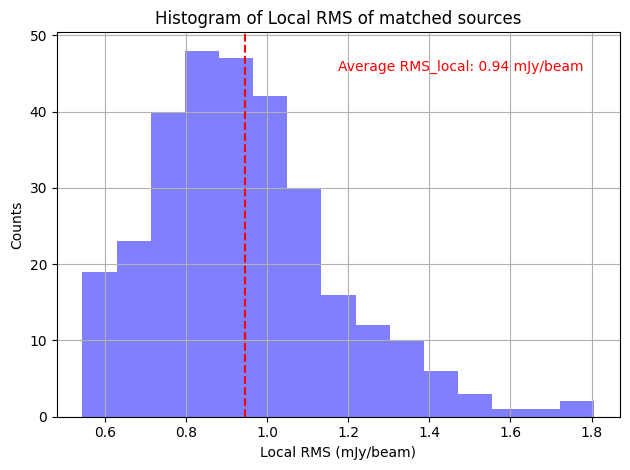

In [ ]:
#
# Convert Jy/beam to mJy/beam
rms = spectral_index[' Isl_rms']*1000  # Multiply by 1000 to convert to mJy/beam

# Plot histogram of 'Isl_rms' values
#plt.figure(figsize=(10, 6))
plt.hist(rms, bins='auto', color='blue', alpha=0.5)
plt.xlabel('Local RMS (mJy/beam)')
plt.ylabel('Counts')
plt.title('Histogram of Local RMS of matched sources')
plt.grid()

# Calculate and display the average Spectral Index
avg_rms = rms.mean()
plt.text(0.5, 0.9, f'Average RMS_local: {avg_rms:.2f} mJy/beam', transform=plt.gca().transAxes, fontsize=10, color='red')
plt.axvline(x=avg_rms, color='red', linestyle='--')
plt.tight_layout()
plt.show()

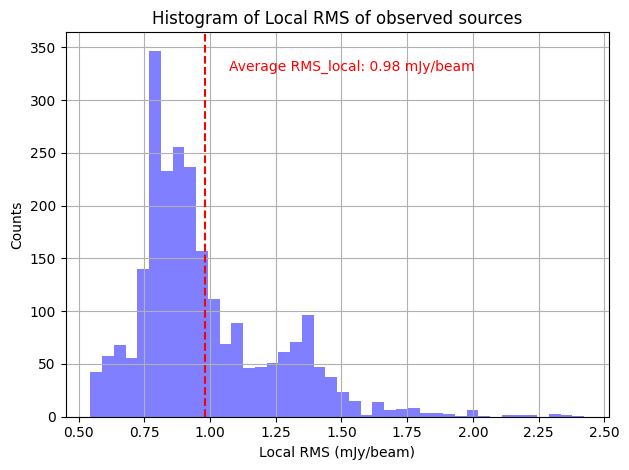

In [ ]:
# Convert Jy/beam to mJy/beam
rms_all = all_sources[' Isl_rms']*1000

# Plot histogram of 'Isl_rms' values
#plt.figure(figsize=(10, 6))
plt.hist(rms_all, bins='auto', color='blue', alpha=0.5)
plt.xlabel('Local RMS (mJy/beam)')
plt.ylabel('Counts')
plt.title('Histogram of Local RMS of observed sources')
plt.grid()

# Calculate and display the average Spectral Index
avg_rms_all = rms_all.mean()
plt.text(0.3, 0.9, f'Average RMS_local: {avg_rms_all:.2f} mJy/beam', transform=plt.gca().transAxes, fontsize=10, color='red')
plt.axvline(x=avg_rms_all, color='red', linestyle='--')
plt.tight_layout()
plt.show()

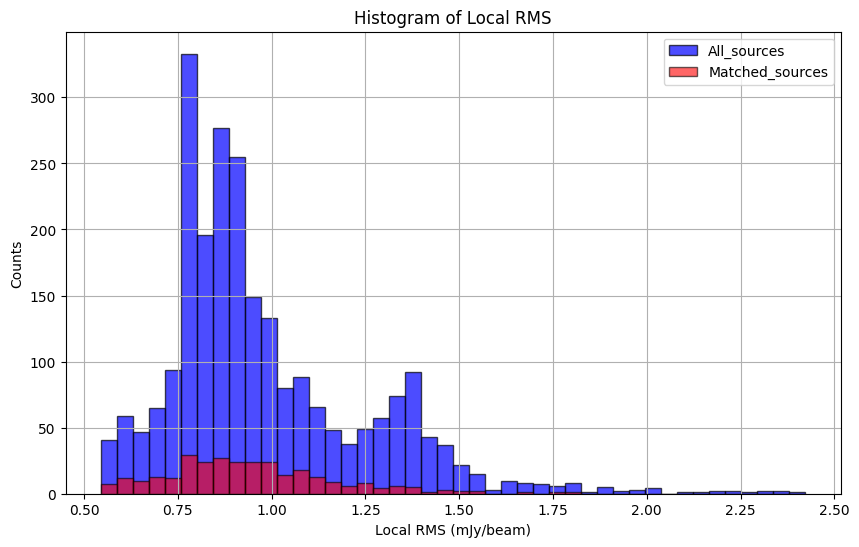

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot histogram of 'Isl_rms' values
#plt.figure(figsize=(10, 6))
bins = np.histogram_bin_edges(np.concatenate((rms_all, rms)), bins='auto')
ax.hist(rms_all,bins=bins,color='blue',alpha=0.7,histtype='bar', edgecolor='black',label='All_sources')
ax.hist(rms, bins=bins, color='red', alpha=0.6,histtype='bar', edgecolor='black',label='Matched_sources')
plt.xlabel('Local RMS (mJy/beam)')  # Update the label
plt.ylabel('Counts')
plt.title('Histogram of Local RMS')
plt.legend()
plt.grid()

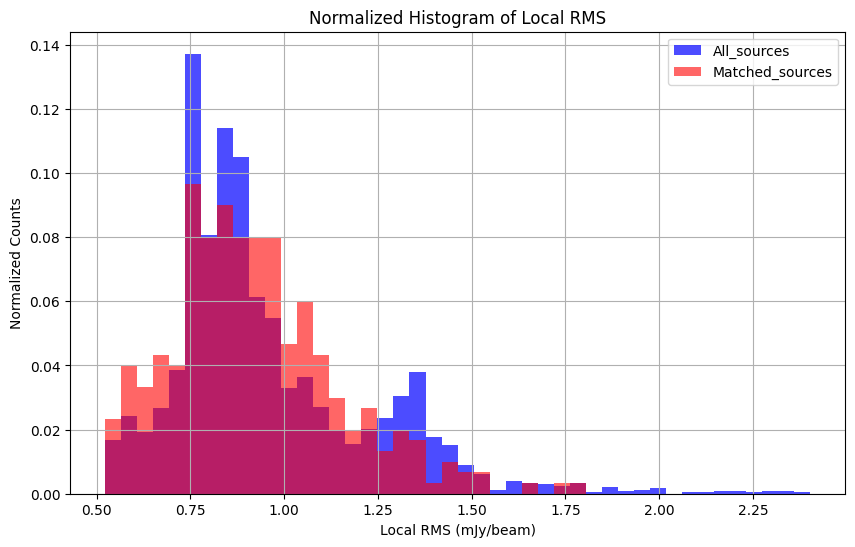

In [ ]:
combined_data = np.concatenate((rms_all, rms))
bins = np.histogram_bin_edges(combined_data, bins='auto')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histograms with the same bins and normalize by the total number of data points
hist_all, _ = np.histogram(rms_all, bins=bins)
hist_matched, _ = np.histogram(rms, bins=bins)

norm_hist_all = hist_all / len(rms_all)
norm_hist_matched = hist_matched / len(rms)

ax.bar(bins[:-1], norm_hist_all, width=np.diff(bins), color='blue', alpha=0.7, label='All_sources')
ax.bar(bins[:-1], norm_hist_matched, width=np.diff(bins), color='red', alpha=0.6, label='Matched_sources')

plt.xlabel('Local RMS (mJy/beam)')
plt.ylabel('Normalized Counts')
plt.title('Normalized Histogram of Local RMS')
plt.grid()
plt.legend()

plt.show()


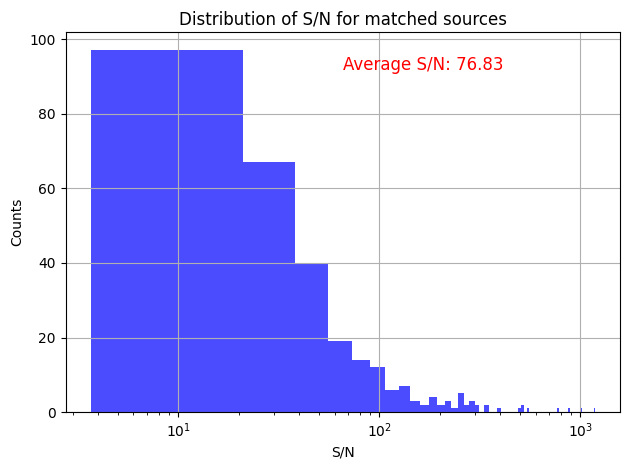

In [ ]:
#Plot of S/N

plt.hist(spectral_index['S/N'], bins='auto', color='blue', alpha=0.7)
plt.xlabel('S/N')
plt.ylabel('Counts')
plt.title('Distribution of S/N for matched sources')
plt.grid()

# Calculate and display the average Spectral Index
avg_snr = spectral_index['S/N'].mean()
plt.text(0.5, 0.9, f'Average S/N: {avg_snr:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')
plt.xscale('log')
plt.tight_layout()
plt.show()

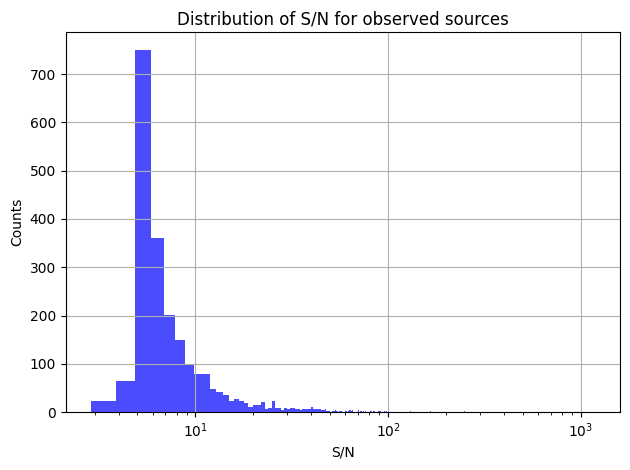

In [ ]:
#Plot of S/N

plt.hist(all_sources['S/N'], bins='auto', color='blue', alpha=0.7)
plt.xlabel('S/N')
plt.ylabel('Counts')
plt.title('Distribution of S/N for observed sources')
plt.grid()

# Calculate and display the average Spectral Index
avg_snr_all = all_sources['S/N'].mean()
#plt.text(0.5, 0.9, f'Average S/N: {avg_snr:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')
plt.xscale('log')
plt.tight_layout()
plt.show()

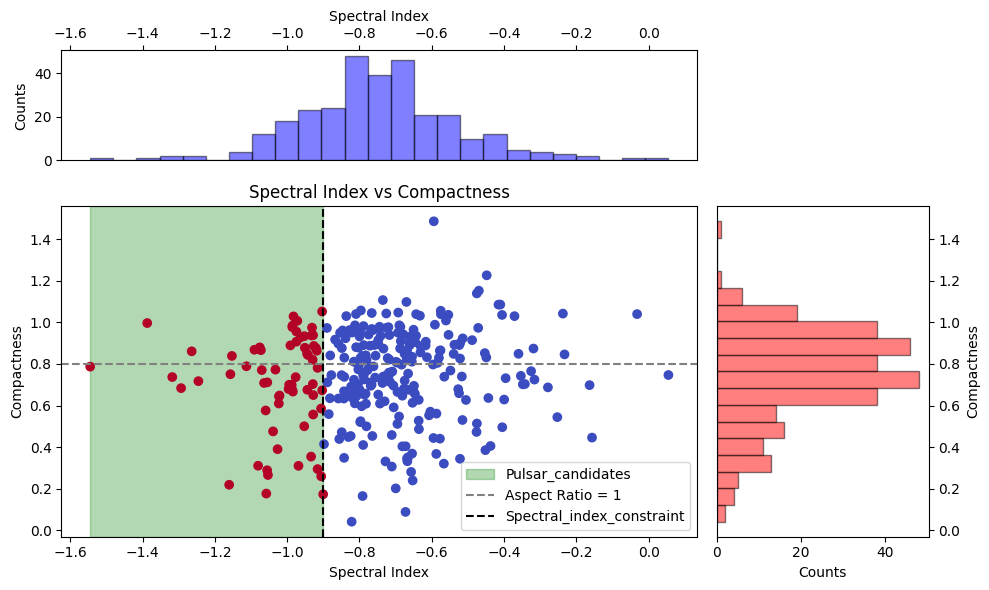

In [ ]:
# Using Aspect Ratio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a 2x2 grid layout
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3])

# Scatter plot with color-coding for pulsar candidates
ax_scatter = fig.add_subplot(gs[1, 0])
plt.axvspan(xmin=spectral_index['Spectral_index'].min(), xmax=-0.9, alpha=0.3, color='g', label='Pulsar_candidates')
scatter = ax_scatter.scatter(spectral_index['Spectral_index'], spectral_index['Compactness'],c=spectral_index['Pulsar_Candidate'], cmap='coolwarm', alpha=1)

ax_scatter.axhline(y=0.8, color='gray', linestyle='--', label='Aspect Ratio = 1')
ax_scatter.axvline(x=-0.9, color='black', linestyle='--', label='Spectral_index_constraint')

ax_scatter.set_xlabel('Spectral Index')
ax_scatter.set_ylabel('Compactness')
ax_scatter.set_title('Spectral Index vs Compactness')
ax_scatter.legend()

# Create histogram for Compactness along the right side
ax_compactness_hist = fig.add_subplot(gs[1, 1])
ax_compactness_hist.hist(spectral_index['Compactness'], bins='auto', orientation='horizontal', color='red', alpha=0.5,histtype='bar',edgecolor='black')
ax_compactness_hist.set_xlabel('Counts')
ax_compactness_hist.set_ylabel('Compactness')
ax_compactness_hist.yaxis.tick_right()
ax_compactness_hist.yaxis.set_label_position('right')

# Create histogram for Spectral Index along the top side
ax_spectral_index_hist = fig.add_subplot(gs[0, 0])
ax_spectral_index_hist.hist(spectral_index['Spectral_index'], bins='auto', orientation='vertical', color='blue', alpha=0.5,histtype='bar',edgecolor='black')
ax_spectral_index_hist.set_ylabel('Counts')
ax_spectral_index_hist.set_xlabel('Spectral Index')
ax_spectral_index_hist.xaxis.tick_top()
ax_spectral_index_hist.xaxis.set_label_position('top')


# Adjust layout
plt.tight_layout()
plt.show()

Scatter Plots

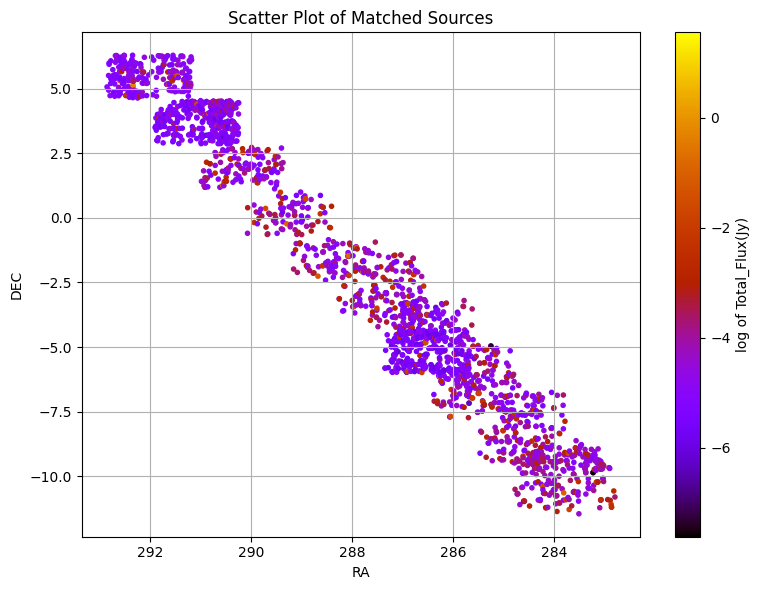

In [ ]:
# Create scatter plot with color coding based on 'Flux' values
plt.figure(figsize=(8, 6))
scatter = plt.scatter(all_sources[' RA'], all_sources[' DEC'], c=np.log(all_sources[' Total_flux']), cmap='gnuplot',marker='.')
plt.gca().invert_xaxis()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Scatter Plot of Matched Sources')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('log of Total_Flux(Jy)')
plt.grid()
plt.tight_layout()
plt.show()

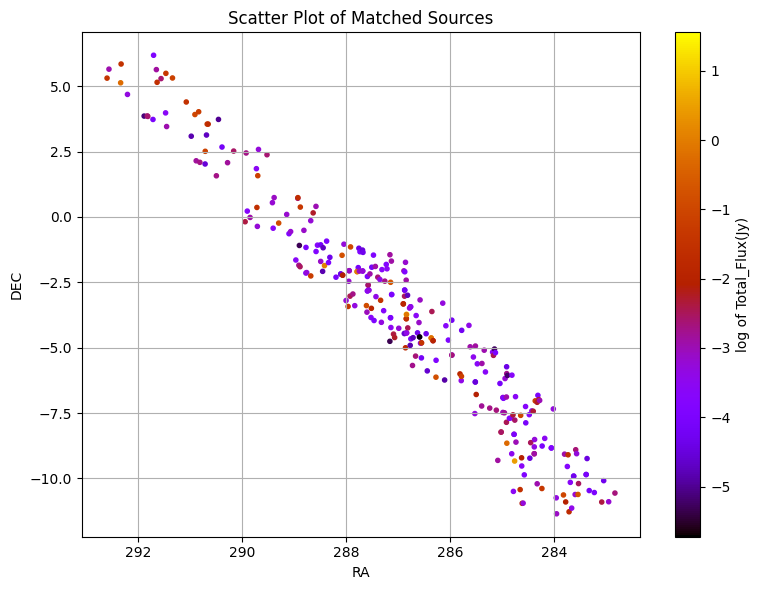

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(spectral_index[' RA'], spectral_index[' DEC'], c=np.log(spectral_index[' Total_flux']), cmap='gnuplot',marker='.')
plt.gca().invert_xaxis()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Scatter Plot of Matched Sources')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('log of Total_Flux(Jy)')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
spectral_index.columns


Index([' Isl_id', ' RA', ' E_RA', ' DEC', ' E_DEC', ' Total_flux',
       ' E_Total_flux', ' Peak_flux', ' E_Peak_flux', ' RA_max', ' E_RA_max',
       ' DEC_max', ' E_DEC_max', ' Maj', ' E_Maj', ' Min', ' E_Min', ' PA',
       ' E_PA', ' Maj_img_plane', ' E_Maj_img_plane', ' Min_img_plane',
       ' E_Min_img_plane', ' PA_img_plane', ' E_PA_img_plane', ' DC_Maj',
       ' E_DC_Maj', ' DC_Min', ' E_DC_Min', ' DC_PA', ' E_DC_PA',
       ' DC_Maj_img_plane', ' E_DC_Maj_img_plane', ' DC_Min_img_plane',
       ' E_DC_Min_img_plane', ' DC_PA_img_plane', ' E_DC_PA_img_plane',
       ' Isl_Total_flux', ' E_Isl_Total_flux', ' Isl_rms', ' Isl_mean',
       ' Resid_Isl_rms', ' Resid_Isl_mean', ' S_Code', 'RA_SPIDX', 'DEC_SPIDX',
       'sep_arcsecods', 'Total_flux_NVSS', 'E_Total_flux_NVSS',
       'Total_flux_TGSS', 'E_Total_flux_TGSS', 'Spidx', 'E_Spidx', 'Sr.no',
       'Spectral_index', 'E_Spectral_index', 'S/N', 'Flux_ratio',
       'Compactness', 'Pulsar_Candidate', 'Pulsar_Candidate_spidx

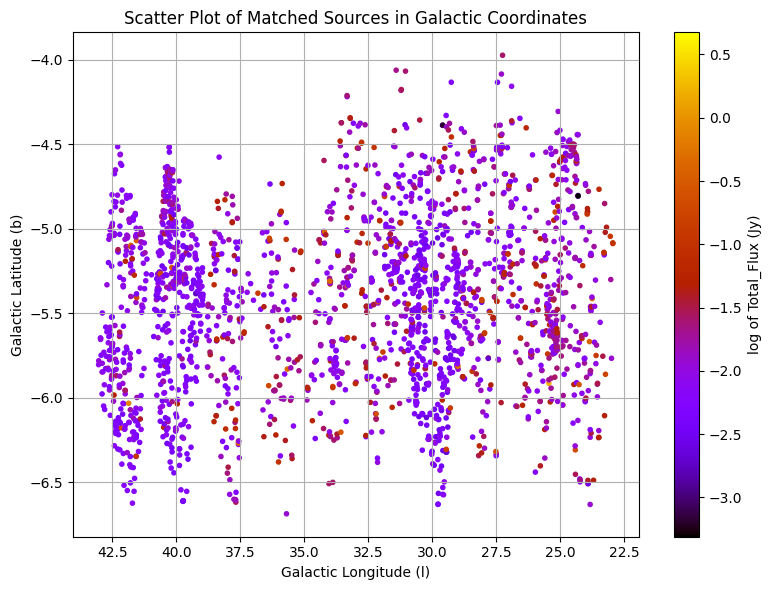

In [ ]:
# Convert equatorial (RA, DEC) coordinates to Galactic (l, b) coordinates
coords_equatorial = SkyCoord(all_sources[' RA'],all_sources[' DEC'], unit=(u.deg, u.deg))
coords_galactic = coords_equatorial.transform_to(Galactic)

# Create scatter plot with color coding based on 'Sep' values
plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords_galactic.l, coords_galactic.b, c=np.log10(all_sources[' Total_flux']), cmap='gnuplot',marker='.')
plt.gca().invert_xaxis()
plt.xlabel('Galactic Longitude (l)')
plt.ylabel('Galactic Latitude (b)')
plt.title('Scatter Plot of Matched Sources in Galactic Coordinates')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('log of Total_Flux (Jy)')
plt.grid()
plt.tight_layout()
plt.show()

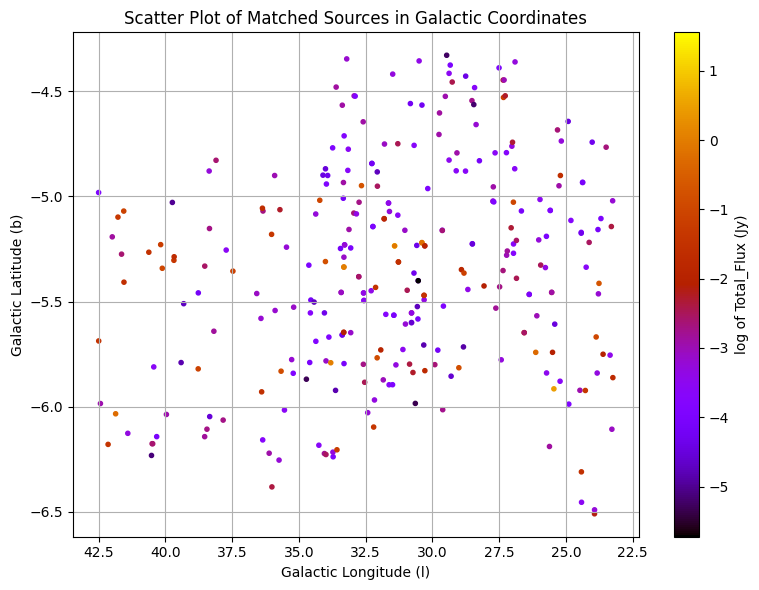

In [ ]:
# Convert equatorial (RA, DEC) coordinates to Galactic (l, b) coordinates
coords_equatorial = SkyCoord(spectral_index[' RA'],spectral_index[' DEC'], unit=(u.deg, u.deg))
coords_galactic = coords_equatorial.transform_to(Galactic)

# Create scatter plot with color coding based on 'Sep' values
plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords_galactic.l, coords_galactic.b, c=np.log(spectral_index[' Total_flux']), cmap='gnuplot',marker='.')
plt.gca().invert_xaxis()
plt.xlabel('Galactic Longitude (l)')
plt.ylabel('Galactic Latitude (b)')
plt.title('Scatter Plot of Matched Sources in Galactic Coordinates')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('log of Total_Flux (Jy)')
plt.grid()
plt.tight_layout()
plt.show()

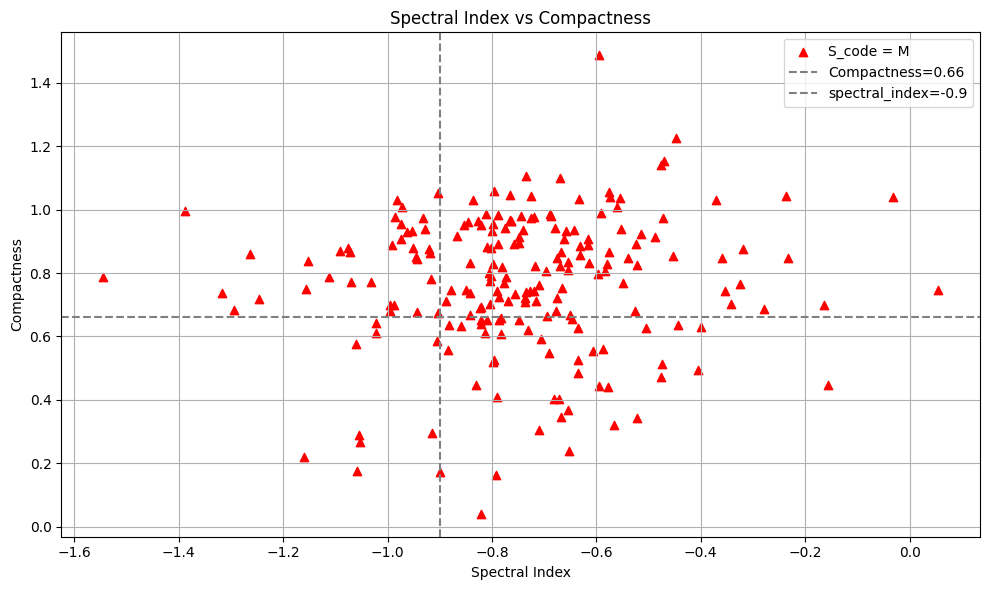

In [ ]:
plt.figure(figsize=(10, 6))

# Plot all points
#scatter = plt.scatter(spectral_index['Spectral_index'], spectral_index['Compactness'], c=spectral_index['Compactness'], cmap='gnuplot')

# Mark sources with 'M' as their 'S_code' with a different marker
spectral_index[' S_Code'] = spectral_index[' S_Code'].str.strip()
m_sources = spectral_index[spectral_index[' S_Code'] == 'S']
plt.scatter(m_sources['Spectral_index'], m_sources['Compactness'], c='red', marker='^', label='S_code = M')

plt.axhline(y=0.66, color='gray', linestyle='--', label='Compactness=0.66')
plt.axvline(x=-0.9, color='gray', linestyle='--', label='spectral_index=-0.9')

plt.xlabel('Spectral Index')
plt.ylabel('Compactness')
plt.title('Spectral Index vs Compactness')
cbar = plt.colorbar(scatter)
cbar.set_label('Compactness(1/flux_ratio)')
plt.legend()

plt.tight_layout()
plt.grid()
plt.show()


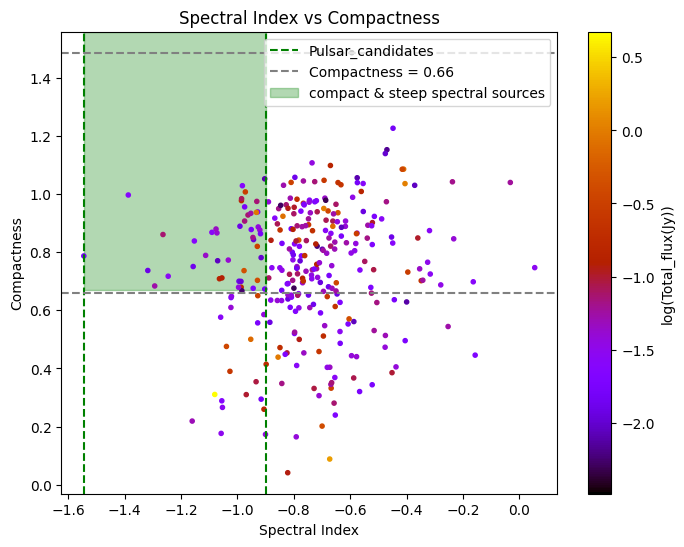

In [ ]:
# Assuming you have a DataFrame named 'spectral_index' with columns 'Spectral_index' and 'Compactness'
plt.figure(figsize=(8, 6))
# Create the scatter plot

# Define the x and y boundaries for the shaded box
xmin = spectral_index['Spectral_index'].min()
xmax = -0.9
ymin = 0.66
ymax = spectral_index['Compactness'].max()

# Plot vertical lines to define the box
plt.axvline(xmin, color='g', linestyle='--', label='Pulsar_candidates')
plt.axvline(xmax, color='g', linestyle='--')
plt.axhline(ymin, color='gray', linestyle='--', label='Compactness = 0.66')
plt.axhline(ymax, color='gray', linestyle='--')

# Fill the area between the lines
plt.axvspan(xmin, xmax,ymin=0.44, alpha=0.3, color='g', label='compact & steep spectral sources')
scatter=plt.scatter(spectral_index['Spectral_index'], spectral_index['Compactness'], c=np.log10(spectral_index[' Total_flux']), cmap='gnuplot', marker='.')

plt.xlabel('Spectral Index')
plt.ylabel('Compactness')
plt.title('Spectral Index vs Compactness')
cbar = plt.colorbar(scatter)
cbar.set_label('log(Total_flux(Jy))')
plt.legend()
plt.show()

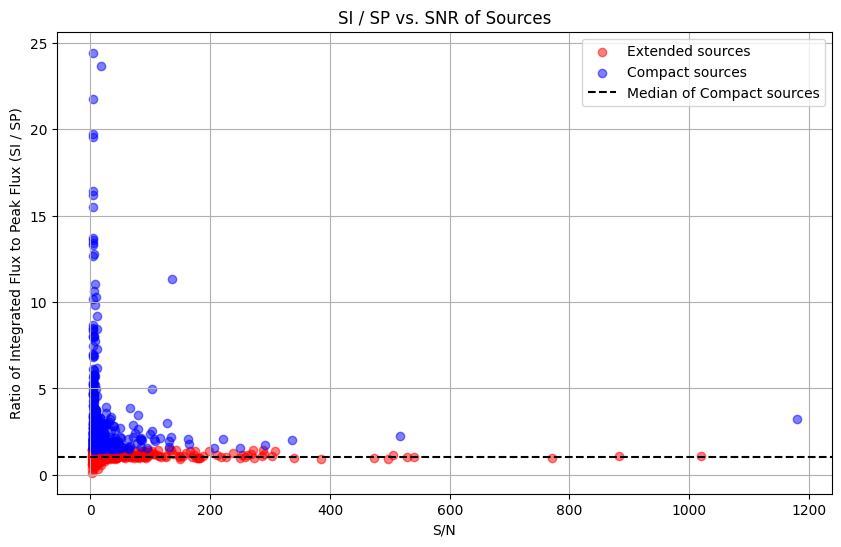

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define the criteria for compact and extended sources
compact_sources = all_sources[all_sources['Flux_ratio'] <= 1.5]
extended_sources = all_sources[all_sources['Flux_ratio'] > 1.5]

# Scatter plot for compact sources in red
plt.scatter(compact_sources['S/N'], compact_sources['Flux_ratio'], alpha=0.5, color='red', label='Extended sources')

# Scatter plot for extended sources in blue
plt.scatter(extended_sources['S/N'], extended_sources['Flux_ratio'], alpha=0.5, color='blue', label='Compact sources')

# Calculate median and standard deviation for the unresolved sources
median_compact = np.median(compact_sources['Flux_ratio'])
std_compact = np.std(compact_sources['Flux_ratio'])

# Plot dashed black line for the median of compact sources
plt.axhline(median_compact, linestyle='--', color='black', label='Median of Compact sources')

# Calculate the -2 sigma line (two standard deviations below the median)
sigma_minus_2 = median_compact - 2 * std_compact


plt.xlabel('S/N')
plt.ylabel('Ratio of Integrated Flux to Peak Flux (SI / SP)')
plt.title('SI / SP vs. SNR of Sources')
plt.grid()
plt.legend()
plt.show()

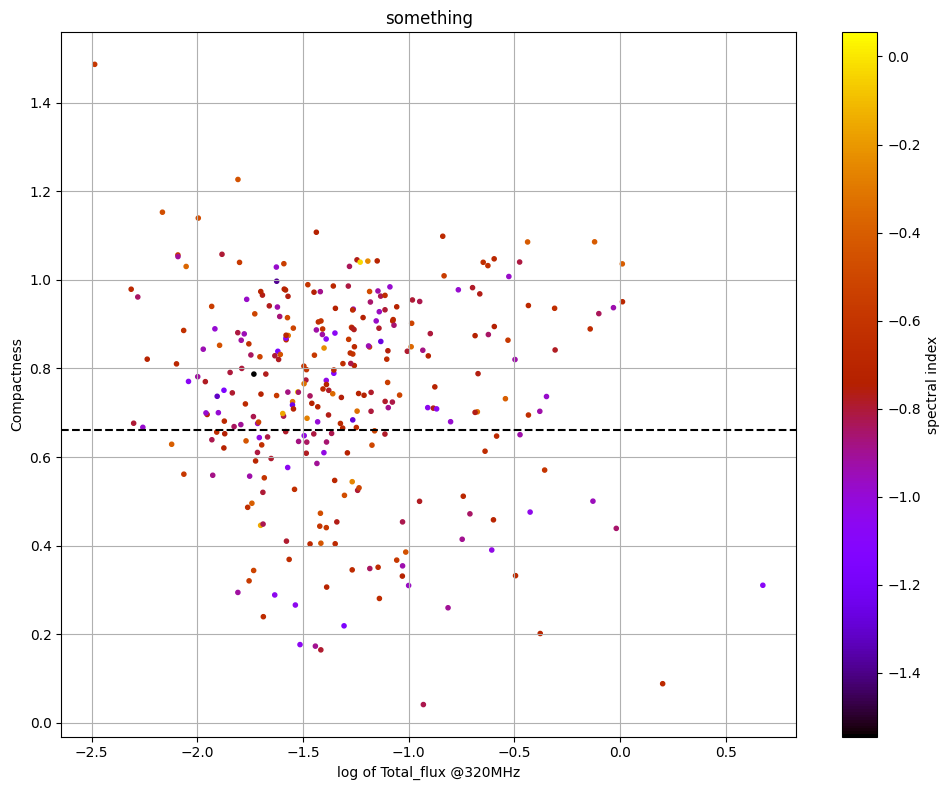

In [ ]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(np.log10(spectral_index[' Total_flux']),spectral_index['Compactness'], c=spectral_index['Spectral_index'], cmap='gnuplot',marker='.')
plt.axhline(y=0.66, linestyle='--', color='black', label='Compactness threshold')
plt.ylabel('Compactness')
plt.xlabel('log of Total_flux @320MHz')
plt.title('something')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('spectral index')
plt.grid()
plt.tight_layout()
plt.show()

{'Total_flux': array([0.78408463, 0.48788885, 0.24241945, 0.06860789, 0.82859373,
        0.46438307, 0.72917673, 0.92238691, 0.76701598, 0.55697107,
        0.84529761, 0.47756896, 0.45388012, 0.17431045, 0.44786788,
        0.30684694, 0.89606643, 0.43496047, 0.45313137, 0.91588453,
        0.69787574, 0.37518748, 0.9105478 , 0.97475082, 0.76351669,
        0.25603398, 0.95780847, 0.14638247, 0.0515498 , 0.18071478,
        0.03687352, 0.8398536 , 0.51765472, 0.4981518 , 0.86506303,
        0.78115228, 0.45832282, 0.54474423, 0.96507329, 0.4339044 ,
        0.53434795, 0.80748313, 0.1571466 , 0.17871094, 0.72844457,
        0.18730705, 0.51344041, 0.84850354, 0.5548423 , 0.07460448,
        0.78041157, 0.77033336, 0.78417296, 0.85303457, 0.20297154,
        0.85491509, 0.31679887, 0.00810096, 0.44379319, 0.31221014,
        0.52811802, 0.12717373, 0.74076287, 0.64128104, 0.86688519,
        0.22321922, 0.31044751, 0.05157818, 0.42514297, 0.15411489,
        0.70509303, 0.52200643, 0.

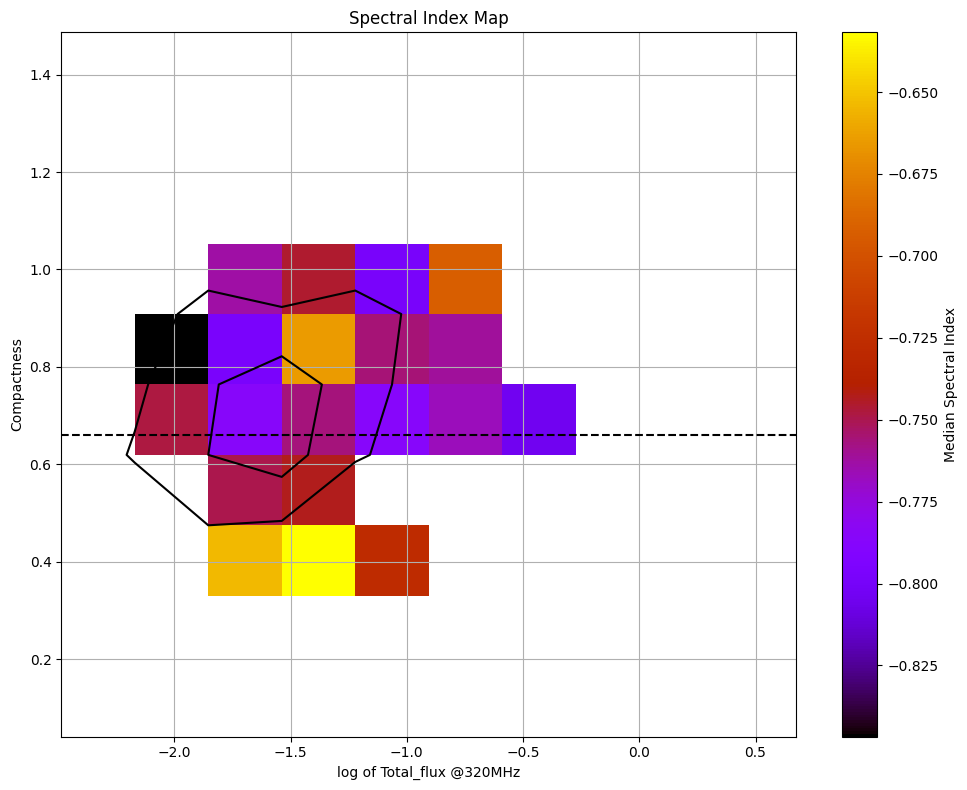

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have actual data in 'spectral_index' dictionary
# Replace this with your actual data

# Convert the Series to NumPy arrays
total_flux = spectral_index[' Total_flux'].values
compactness = spectral_index['Compactness'].values
spectral_index_values = spectral_index['Spectral_index'].values

# Define the number of bins and the range for the 2D histogram
num_bins = 10
total_flux_range = [np.log10(total_flux.min()), np.log10(total_flux.max())]
compactness_range = [compactness.min(), compactness.max()]

# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(
    np.log10(total_flux),
    compactness,
    bins=num_bins,
    range=[total_flux_range, compactness_range]
)

# Calculate the median spectral index for each bin
medians = np.zeros((num_bins, num_bins), dtype=float)
for i in range(num_bins):
    for j in range(num_bins):
        bin_mask = (
            (np.log10(total_flux) >= xedges[i]) &
            (np.log10(total_flux) < xedges[i + 1]) &
            (compactness >= yedges[j]) &
            (compactness < yedges[j + 1])
        )
        if np.sum(bin_mask) >= 5:
            medians[i, j] = np.median(spectral_index_values[bin_mask])

# Mask bins with less than five objects
masked_medians = np.ma.masked_where(hist < 5, medians)

# Create the heatmap with color-coded medians
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('gnuplot')
heatmap = plt.pcolormesh(xedges, yedges, masked_medians.T, cmap=cmap)

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('Median Spectral Index')

# Add black contours to show source count per bin
contour_levels = [10, 20, 40, 80, 160]
contours = plt.contour(xedges[:-1], yedges[:-1], hist.T, levels=contour_levels, colors='black')

plt.axhline(y=0.66, linestyle='--', color='black', label='Compactness threshold')
plt.ylabel('Compactness')
plt.xlabel('log of Total_flux @320MHz')
plt.title('Spectral Index Map')

plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
spectral_index.columns


NameError: ignored